# Импортируем библиотеки

In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import lightgbm as lgb
from sklearn.inspection import permutation_importance
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import os
import contextlib
import warnings
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import  GridSearchCV
from tqdm import tqdm
import statsmodels.api as sm

# Загрузка данных

Будем использовать mte кодировку, так как будем работать с lightgbm

In [2]:
df_le=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_le.csv")
df_mte=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_feat_eng_mte.csv")
df_le=df_le.drop('Unnamed: 0', axis=1)
df_mte=df_mte.drop('Unnamed: 0', axis=1)
df_mte.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,...,metro_line,metro_distance,distr*time,Kre*time,Kre*area,year*area,year*repair,year*floors,distr*area,area/num+1
9634,Кунцевская,15.0,1.555949e+07,19.0,1700.0,3.5,3.579406e+07,6400000.0,14.0,12.0,...,4.907639e+07,2.42,3.981117e+08,186.300,235.98,32300.0,6.084989e+10,23800.0,5.042748e+08,0.000001
17972,Римская,7.5,1.555949e+07,23.5,1700.0,11.0,2.299117e+07,20726560.0,25.0,14.0,...,2.451582e+07,4.42,1.823331e+08,33.150,103.87,39950.0,3.908499e+10,42500.0,5.713103e+08,0.000002
24613,Борисово,15.5,1.555949e+07,19.0,1700.0,12.0,2.299117e+07,12787213.0,52.0,30.0,...,2.451582e+07,4.81,2.832050e+08,214.055,262.39,32300.0,3.908499e+10,88400.0,3.471545e+08,0.000001
26228,Чкаловская,7.5,2.651027e+07,75.0,1700.0,15.0,5.234562e+07,99000000.0,6.0,2.0,...,2.451582e+07,0.88,2.540575e+08,14.100,141.00,127500.0,8.898756e+10,10200.0,2.540575e+09,0.000003
8768,Нагатинская,7.5,1.555949e+07,23.0,1700.0,9.0,2.299117e+07,15800000.0,26.0,4.0,...,2.633074e+07,5.79,1.568573e+08,58.425,179.17,39100.0,3.908499e+10,44200.0,4.810290e+08,0.000001


In [3]:
df_mte.shape

(27974, 27)

# Важности признаков

Будем двигаться от более легких методов к более сложным.

## Split 

Посмотрим простейший способ получения важности под названием split, который встроен в lightgbm. Важность признака определяется по количеству использований признака для сплита в течение всего процесса обучения.

Для этого сначала обучим градиентный бустинг на кросс-валидации. Также перед этим потюним модель.

In [4]:
X,y=df_mte.drop(['coord_width', 'coord_len', 'link', 'address', 'metro_name', 'price', 'date'], axis=1), df_mte['price']
X_tr, X_v,y_tr, y_v=train_test_split(X,y, test_size=0.8)

In [5]:
lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42)
param_grid={'learning_rate':[0.01,0.05,0.1,0.2], 'n_estimators':[1000,2000, 4000], 'lambda_l1':[5,15,30]}
gd=GridSearchCV(lgbm, param_grid, cv=5)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    gd.fit(X,y)
print(f'best params: {gd.best_params_}')

best params: {'lambda_l1': 30, 'learning_rate': 0.1, 'n_estimators': 4000}


Считаем важности признаков на кросс-валидации.

In [6]:
skf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
importance=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X, y):
            lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, **gd.best_params_)
            lgbm.fit(X.loc[tr_ind,:], y.loc[tr_ind])
            importance.append(lgbm.booster_.feature_importance())


In [7]:
feat_imp=np.mean(np.array(importance), axis=0)
feat_imp

array([ 1439.5 ,   863.75,  8183.25,  3658.5 ,  9142.25,  1160.25,
        4389.  ,  8871.  ,  6773.  ,  4203.  ,  3147.  ,  8477.5 ,
        5983.  ,  6504.  ,  9131.75,  6381.5 ,  5780.75,  6883.5 ,
        8081.  , 10946.5 ])

Отсортированный словарь "признак": количество сплитов.

In [8]:
dict_imp={X.columns[i]:feat_imp[i] for i in range(X.shape[1])}
dict_imp_s=sorted(dict_imp, key=lambda x: dict_imp[x], reverse=True)
f_dict={}
for i in dict_imp_s:
    f_dict[i]=dict_imp[i]
f_dict

{'area/num+1': 10946.5,
 'kitchen_area': 9142.25,
 'Kre*area': 9131.75,
 'num_floor': 8871.0,
 'metro_distance': 8477.5,
 'total_area': 8183.25,
 'distr*area': 8081.0,
 'year*floors': 6883.5,
 'distance_to_Kremlin': 6773.0,
 'Kre*time': 6504.0,
 'year*area': 6381.5,
 'distr*time': 5983.0,
 'year*repair': 5780.75,
 'floors': 4389.0,
 'district': 4203.0,
 'year_house': 3658.5,
 'metro_line': 3147.0,
 'time_to_metro': 1439.5,
 'repair': 1160.25,
 'num_rooms': 863.75}

Визуализация

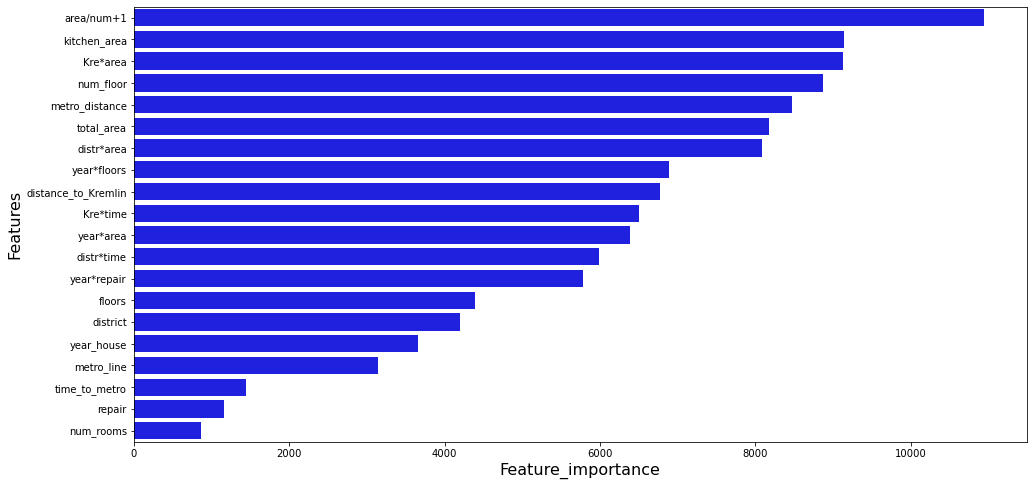

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(16, 8))
    plt.xlabel('Feature_importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    sns.barplot(list(f_dict.values()), list(f_dict.keys()), color='blue')

## Permutation importance

Метод основан на перестановке. Модель обучается на части данных, предсказывает результат на валидационной части данных с каким то качеством. Потом признак перемешивается на валидации, и модель делает предсказание еще раз. Разностью в качестве до перемешивания и после оценивается важность признака.

Смотрим важность на кроссвалидации.

In [10]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
perm_imp=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in tqdm(skf.split(X, y)):
            
            lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, **gd.best_params_)
            lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            
            perm_imp.append(permutation_importance(lgbm, X.iloc[val_ind], y.iloc[val_ind], random_state=42, scoring='neg_mean_absolute_percentage_error', n_repeats=30))
            


5it [26:08, 313.66s/it]


Создаем табличку

In [11]:
perm_df=pd.DataFrame(columns=['fold №1', 'fold №2', 'fold №3', 'fold №4', 'fold №5', 'mean'], index=X.columns)
for i in range(1,6):
    perm_df[f'fold №{i}']=perm_imp[i-1]['importances_mean']
perm_df['mean']=perm_df.mean(axis=1)

In [12]:
perm_df

,fold №1,fold №2,fold №3,fold №4,fold №5,mean
time_to_metro,0.035034,0.024513,0.028373,0.024572,0.026018,0.027702
num_rooms,0.044116,0.046604,0.037754,0.050420,0.053821,0.046543
total_area,0.166626,0.214201,0.205163,0.182392,0.210003,0.195677
year_house,0.017176,0.017490,0.020599,0.018413,0.022147,0.019165
kitchen_area,0.019954,0.021396,0.021736,0.020381,0.020277,0.020749
repair,0.014332,0.013748,0.015575,0.016580,0.014922,0.015031
floors,0.034986,0.028880,0.048991,0.035475,0.034828,0.036632
num_floor,0.028275,0.027130,0.023429,0.026666,0.024646,0.026029
distance_to_Kremlin,0.116105,0.114220,0.133710,0.137547,0.125668,0.125450
district,0.052370,0.069242,0.056342,0.080143,0.066096,0.064838


Визуализация

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

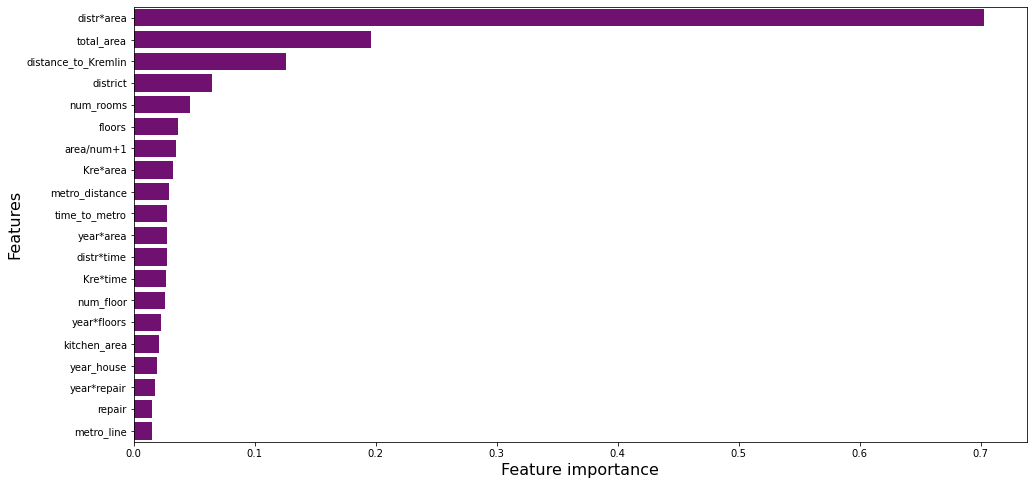

In [13]:
plt.figure(figsize=(16,8))
a=perm_df['mean'].sort_values()[::-1]
plt.xlabel('Feature importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
sns.barplot(x=a.values, y=a.index, color='purple')

Результаты получились слегка отличающиеся от метода split.

## Жадное удаление признаков

Метод заключается в том, чтобы поочередно удалять признаки, обучать модель на новом датасете и сранивать качество с базом датасетом. Чем больше падение качества- тем выше значимость признака

Каждый раз будем смотреть качество на кросс валидации. Для каждого нового датасета надо будет "тюнить" модель

Качество базового датасета.

In [14]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
errors=[]

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for tr_ind, val_ind in skf.split(X, y):
            lgbm=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
            lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            errors.append(mape(y.iloc[val_ind],lgbm.predict(X.iloc[val_ind,:])))
            
print(f'MAPE for f dataset: {np.mean(errors)}')

all_feat_error=np.mean(errors)

MAPE for f dataset: 0.1494413386488436


Поочередно удаляем признаки, тюним модель, получаем качество на кросс-валидации. Сохраняем в словарь.

In [15]:
errors_dict={}

feat_to_drop=[]
col_rfe=perm_df['mean'].sort_values().index
t=0.00001
c=list(f_dict.keys())[::-1]

for i in c:
    
    X_time=X.drop(feat_to_drop+[i], axis=1)

        
        
    errors_t=[]
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            for tr_ind, val_ind in skf.split(X_time, y):
                lgbm=LGBMRegressor(bagging_fraction=0.5, **gd.best_params_, random_state=42)
                lgbm.fit(X_time.iloc[tr_ind,:], y.iloc[tr_ind])
                errors_t.append(mape(y.iloc[val_ind],lgbm.predict(X_time.iloc[val_ind,:])))
                
    errors_dict[i]=np.mean(errors_t)
    
    print(f'Error with drop {i}: {errors_dict[i]}')
    print(f'Error with all features: {all_feat_error}')
    diff_err=errors_dict[i]-all_feat_error
    
    print(f'Difference between errors for {i}: {diff_err}')
    
    if diff_err< t:
        feat_to_drop.append(i)
        print(f'Delete {i}')
    else:
        print(f'Remain {i}')
    print()

Error with drop num_rooms: 0.14941650003362153
Error with all features: 0.1494413386488436
Difference between errors for num_rooms: -2.4838615222066984e-05
Delete num_rooms

Error with drop repair: 0.14980191505954316
Error with all features: 0.1494413386488436
Difference between errors for repair: 0.00036057641069955904
Remain repair

Error with drop time_to_metro: 0.15124561881843815
Error with all features: 0.1494413386488436
Difference between errors for time_to_metro: 0.001804280169594552
Remain time_to_metro

Error with drop metro_line: 0.15027429185016278
Error with all features: 0.1494413386488436
Difference between errors for metro_line: 0.0008329532013191809
Remain metro_line

Error with drop year_house: 0.15002381467053605
Error with all features: 0.1494413386488436
Difference between errors for year_house: 0.0005824760216924518
Remain year_house

Error with drop district: 0.15112348575259332
Error with all features: 0.1494413386488436
Difference between errors for district:

Признаки для удаления

In [16]:
print(feat_to_drop)

['num_rooms', 'year*repair', 'Kre*time']


## Split в динамике

Здесь мы посмотрим важность split в зависимости от максимальной глубины дерева

In [17]:
max_depth=[1,2,3,4,5]
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
dm_imp=[]
for num in max_depth:
    
    importance=[]
    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            for tr_ind, val_ind in skf.split(X, y):
                lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                   **gd.best_params_, max_depth=num)
                
                lgbm.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
                
                importance.append(lgbm.booster_.feature_importance())


    feat_imp=np.mean(np.array(importance), axis=0)
    
    dm_imp.append(feat_imp)


Создадим таблицу

In [18]:
dm_imp_df=pd.DataFrame(columns=[f'depth {i}' for i in range(1, 6)], index=X.columns)

for i in range(1,6):
    dm_imp_df[f'depth {i}']= dm_imp[i-1]
dm_imp_df['mean']=dm_imp_df.mean(axis=1)


In [19]:
dm_imp_df

,depth 1,depth 2,depth 3,depth 4,depth 5,mean
time_to_metro,410.8,368.0,491.6,697.2,944.4,582.40
num_rooms,53.4,143.8,273.8,447.4,657.0,315.08
total_area,800.4,1925.8,3090.8,4509.4,6436.0,3352.48
year_house,314.6,333.6,621.0,1204.2,2128.6,920.40
kitchen_area,223.2,665.6,1744.0,3320.6,5619.4,2314.56
repair,10.0,94.0,209.8,384.4,675.4,274.72
floors,128.2,536.6,980.4,1747.0,2848.0,1248.04
num_floor,53.4,508.8,1192.8,2574.8,4776.8,1821.32
distance_to_Kremlin,274.6,802.4,1786.6,3144.4,4760.4,2153.68
district,148.6,460.8,854.0,1677.0,2695.0,1167.08


Визуализация

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

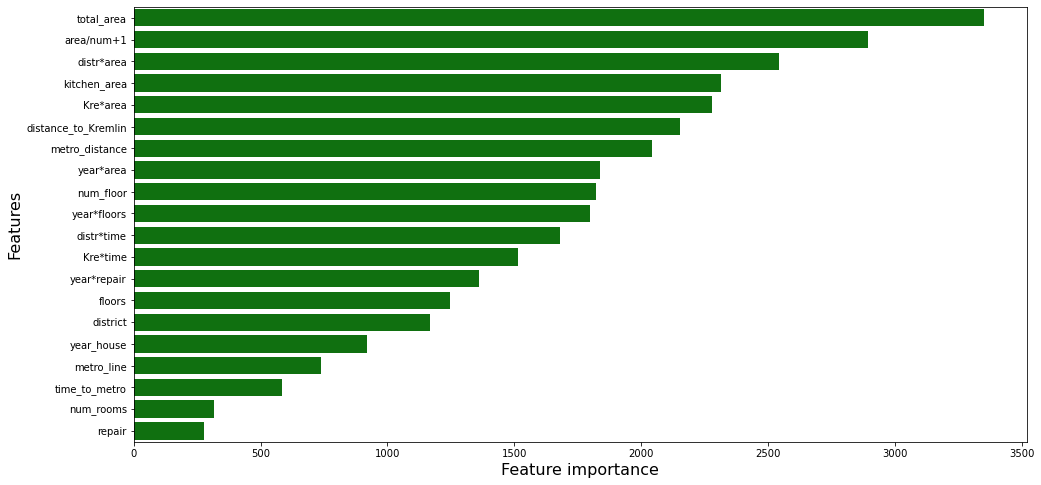

In [20]:
plt.figure(figsize=(16,8))
b=dm_imp_df['mean'].sort_values()[::-1]
plt.xlabel('Feature importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
sns.barplot(x=b.values, y=b.index, color='green')

Разницы особо нет

## Модифицированный backward elimination features

Суть обычного backward elimination features заключается в том, что мы на каждой итерации алгоритма удаляем признак с самым большим p-значением и делаем это до тех пор, пока качество модели не достигнет пика. В нашем случае вместо максимального p-значения мы будем использовать минимальный прирост качества.

In [25]:
fl=True
k=0
col_drop=[]


while len(col_drop)<X.shape[1]:
    col_errors=[]
    for col in set(X.columns.to_list())-set(col_drop):
        
        X_time=X.drop([col]+col_drop, axis=1)
        
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                errors=[]

                for tr_ind, val_ind in skf.split(X_time, y):
                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                       **gd.best_params_)

                    lgbm.fit(X_time.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_time.iloc[val_ind,:])))
    
        
        col_errors.append([col,np.mean(errors)])

    
    min_col=min(col_errors, key=lambda x: x[1])
    
    col_drop.append(min_col[0])
    print(f'Feature "{min_col[0]}" delete with mape {min_col[1]}')
    
    print()
    

Feature "year*repair" delete with mape 0.14832097896805158

Feature "year*area" delete with mape 0.1487054971213422

Feature "year*floors" delete with mape 0.14888157426652432

Feature "area/num+1" delete with mape 0.1484314785648759

Feature "Kre*area" delete with mape 0.1480381205567654

Feature "distr*area" delete with mape 0.14784764460161406

Feature "distr*time" delete with mape 0.14705610330423344

Feature "Kre*time" delete with mape 0.1470698880126026

Feature "metro_line" delete with mape 0.14815501840943662

Feature "kitchen_area" delete with mape 0.14810784670517246

Feature "num_floor" delete with mape 0.15105056311084694

Feature "metro_distance" delete with mape 0.1527486502357588

Feature "year_house" delete with mape 0.15648357859370088

Feature "repair" delete with mape 0.16450074995302408

Feature "time_to_metro" delete with mape 0.17320935106836277

Feature "num_rooms" delete with mape 0.18554432417169195

Feature "distance_to_Kremlin" delete with mape 0.205739693361

Признаки от самого плохого, к самому лучшему.

In [27]:
col_drop

['year*repair',
 'year*area',
 'year*floors',
 'area/num+1',
 'Kre*area',
 'distr*area',
 'distr*time',
 'Kre*time',
 'metro_line',
 'kitchen_area',
 'num_floor',
 'metro_distance',
 'year_house',
 'repair',
 'time_to_metro',
 'num_rooms',
 'distance_to_Kremlin',
 'floors',
 'district',
 'total_area']

# Удаляем признаки

Самые частые кандидаты на удаление

In [28]:
bad_feats=['repair', 'year*repair']

Попробуем разные комбинации для удаления.

In [29]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)          
for i in [[],['repair','year*repair'],['repair'], ['year*repair']]:
    
    errors=[]
    
    X_t=X.drop(i, axis=1)

    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            for tr_ind, val_ind in skf.split(X_t, y):

                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                           **{'lambda_l1': 15, 'learning_rate': 0.05, 'n_estimators': 4000})

                    lgbm.fit(X_t.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_t.iloc[val_ind])))
                          
    print(f'Mape with delete this features: {i} equals {np.mean(errors)}')
    

Mape with delete this features: [] equals 0.15000059838940735
Mape with delete this features: ['repair', 'year*repair'] equals 0.15749484531622066
Mape with delete this features: ['repair'] equals 0.1504385364683617
Mape with delete this features: ['year*repair'] equals 0.15056863744158777


In [30]:
X,y=df_le.drop(['coord_width', 'coord_len', 'link', 'address', 'metro_name', 'price', 'date'], axis=1), df_le['price']
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)          
for i in [[],['repair','year*repair'],['repair'], ['year*repair']]:
    
    errors=[]
    
    X_t=X.drop(i, axis=1)

    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
    
            for tr_ind, val_ind in skf.split(X_t, y):

                    lgbm=LGBMRegressor(bagging_fraction=0.5, random_state=42, 
                                           **{'lambda_l1': 15, 'learning_rate': 0.05, 'n_estimators': 4000})

                    lgbm.fit(X_t.iloc[tr_ind,:], y.iloc[tr_ind])

                    errors.append(mape(y.iloc[val_ind],lgbm.predict(X_t.iloc[val_ind])))
                          
    print(f'Mape with delete this features: {i} equals {np.mean(errors)}')

Mape with delete this features: [] equals 0.15161666717968103
Mape with delete this features: ['repair', 'year*repair'] equals 0.15965952142656878
Mape with delete this features: ['repair'] equals 0.15131672793534645
Mape with delete this features: ['year*repair'] equals 0.1522335322840696


Удалим только repair. Прирост качества на mte довольно низкий, а на le кодировке пристутствие этого признака вообще понизило качество.

In [31]:
df_le=df_le.drop('repair', axis=1)
df_mte=df_mte.drop('repair', axis=1)

# Сохраняем данные

In [32]:
df_le.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_le.csv")
df_mte.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_delete_mte.csv")